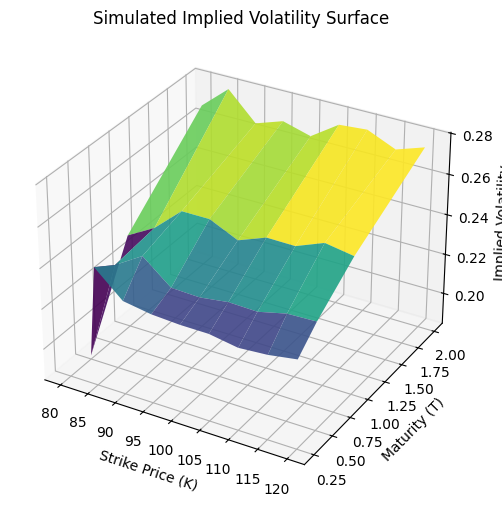

Average absolute error: 0.0054


In [84]:
# Vol surface generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

S0, rf = 100, 0.03
K = np.arange(80, 125, 5)
T = np.array([0.25, 0.5, 1, 2])

def true_vol(K, T):
    return 0.2 + 0.1 * ((K - S0)/S0)**2 + 0.05 * np.sqrt(T)

def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    return call

data = []
for t in T:
    for k in K:
        sigma_true = true_vol(k, t)
        price = bs_call(S0, k, t, rf, sigma_true)
        noise = np.random.uniform(0.98, 1.02)
        noisy_price = price * noise
        data.append([k, t, sigma_true, price, noisy_price])

df = pd.DataFrame(data, columns = ['Strike', 'Maturity', 'TrueVol', 'BS_Price', 'Noisy_Price'])
df

def implied_vol(price, S, K, T, r):
    func = lambda sigma: bs_call(S, K, T, r, sigma) - price
    try:
        return brentq(func, 1e-6, 2.0)
    except ValueError:
        return np.nan

df["ImpliedVol"] = df.apply(lambda row: implied_vol(row["Noisy_Price"], S0, row["Strike"], row["Maturity"], rf), axis=1)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection = '3d')
X, Y = np.meshgrid(K, T)
Z = np.array(df["ImpliedVol"]).reshape(len(T), len(K))
ax.plot_surface(X, Y, Z, cmap = "viridis", alpha = 0.9);
ax.set_xlabel("Strike Price (K)")
ax.set_ylabel("Maturity (T)")
ax.set_zlabel("Implied Volatility")
ax.set_title("Simulated Implied Volatility Surface")
plt.show();

df.head(10)
df.describe()
vol_error = np.mean(abs(df["ImpliedVol"] - df["TrueVol"]))
print(f"Average absolute error: {vol_error:.4f}")